In [97]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer
from torch.utils.data import WeightedRandomSampler  ## TODO come back here and implement with WeightedRandomSampler
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import time

import calibration_fns as cal

from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score

In [2]:
cwd = os.getcwd()
data_folder = cwd + '/Data_External/'

### Step 1. Set up dataset for pytorch

In [3]:
#train, val, test= du.getData(dataDir=dataDir, holdoutDir=holdoutDir,ValCutoff=ValCutoff)
data = pd.read_excel(data_folder + 'sources.xlsx')
data = data.sample(frac=1).reset_index(drop=True)

data["Response"] = data["Response"].astype(str)
data["code"] = data["code"].astype(str)

train_size = int(0.7*len(data))
val_size = int(0.15*len(data))
train_data = data[:train_size]
base_data = data[train_size:train_size + val_size]
target_data = data[train_size + val_size:]

In [4]:
len(train_data)

2029

In [5]:
def get_max_len(tokenizer, train):
    all_sent = np.array(train.Response.values)
    # Encode data
    encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sent]
    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_sentences])
    return max_len

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = get_max_len(tokenizer, train_data) 

In [7]:
print(MAX_LEN)

101


In [8]:
def text_preprocessing_simple(text):
    try:
        text = re.sub(r'\s+', ' ', text).strip()
    except:
        pass
    return text

In [9]:
def preprocessing_for_bert(data, tokenizer, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_simple(str(sent)),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [10]:
class SourcesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.data, self.masks = preprocessing_for_bert(df["Response"], tokenizer, MAX_LEN)
        self.text = df["Response"].reset_index(drop=True)
        labels_enc, unique_labels = pd.factorize(df["code"], sort = True)
        self.labels = torch.tensor(labels_enc, dtype = torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        mask = self.masks[idx]
        label = self.labels[idx]
        return sample, mask, label

In [11]:
labels_enc, unique_labels = pd.factorize(train_data["code"], sort = True)
target_to_class = {i:unique_labels[i] for i in range(len(unique_labels))}

In [12]:
target_to_class

{0: 'L', 1: 'O', 2: 'P', 3: 'S'}

In [13]:
train_dataset = SourcesDataset(train_data, tokenizer, MAX_LEN)
base_dataset = SourcesDataset(base_data, tokenizer, MAX_LEN)
target_dataset = SourcesDataset(target_data, tokenizer, MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/rkf33/.conda/envs/labnotes7/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/rkf33/.conda/envs/labnotes7/lib/python3.12/site-packages/transformers/

In [14]:
len(train_dataset)

2029

In [15]:
train_dataset[2]

(tensor([  101,  2070,  2493,  2071,  2031,  2367,  4781,  2005,  9854,  1006,
          1045,  1012,  1041,  1012,  2028,  2493,  4455,  1037,  2765,  1999,
          2090,  2048, 11702,  2011, 26939,  2091,  2096,  2178,  6241,  2039,
          1007,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 

In [16]:
for data, mask, label in train_dataset:
    break

In [17]:
class_counts = train_data.code.value_counts()

In [18]:
#sample_weights = [1.0 / class_counts[i] for i in train_data.code.values]
class_weights = 1.0 / class_counts
class_weights[1] = class_weights[1] / 4 # underweight "other"
sample_weights = [class_weights[i] for i in train_data.code.values]
class_weights = torch.tensor(class_weights, dtype=torch.float)

train_sampler=WeightedRandomSampler(sample_weights,len(train_dataset), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size = 16, sampler = train_sampler)
base_dataloader = DataLoader(base_dataset, batch_size = 16) 
target_dataloader = DataLoader(target_dataset, batch_size = 16) 

/tmp/ipykernel_268672/3474696145.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights[1] = class_weights[1] / 4 # underweight "other"
/tmp/ipykernel_268672/3474696145.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  class_weights[1] = class_weights[1] / 4 # underweight "other"
/tmp/ipykernel_268672/3474696145.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = torch.tensor(class_weights, dtype=to

In [19]:
class_counts

code
L    1559
O     286
P     117
S      67
Name: count, dtype: int64

In [20]:
for sents, masks, labels in train_dataloader:
    break

In [21]:
sents.shape
masks.shape
labels

tensor([0, 3, 3, 0, 3, 3, 2, 0, 0, 0, 2, 3, 0, 2, 0, 3])

### Step 2. Set up Pytorch Model

In [22]:
class SourcesClassifier(nn.Module):
    def __init__(self, num_classes=4, freeze_bert = False):
        #Where we define all the parts of the model
        super(SourcesClassifier, self).__init__()  # initialize object with everything from the parent class
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 200, num_classes
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        # Connect these parts and return the output
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [23]:
model = SourcesClassifier(num_classes = 4)
print(model)

SourcesClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
example_out = model(sents, masks)

In [25]:
example_out.shape #batch size, num_classes

torch.Size([16, 4])

In [26]:
example_out

tensor([[-0.2821,  0.0272,  0.0481,  0.0045],
        [-0.3086,  0.0218,  0.0325,  0.0115],
        [-0.2296, -0.0017, -0.0285, -0.0651],
        [-0.2282,  0.0026, -0.0115, -0.0044],
        [-0.2742,  0.0450,  0.0783, -0.1086],
        [-0.2557,  0.0645,  0.0073, -0.0371],
        [-0.2895,  0.1354,  0.0804, -0.0641],
        [-0.3101,  0.1319,  0.0425, -0.0096],
        [-0.2513,  0.0317,  0.0446,  0.1071],
        [-0.2384,  0.0637,  0.0586, -0.0371],
        [-0.2666,  0.2010, -0.0441,  0.1369],
        [-0.2742,  0.0450,  0.0783, -0.1086],
        [-0.2699,  0.1096,  0.0022,  0.0042],
        [-0.2480,  0.2608,  0.0224,  0.1369],
        [-0.2148,  0.1166,  0.0008, -0.0189],
        [-0.2353,  0.1287, -0.0269, -0.0179]], grad_fn=<AddmmBackward0>)

### Step 3. The training loop

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
print(device)

cuda:0


In [28]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [29]:
criterion(example_out, labels) # check that the loss function calculates. It won't be any good yet because we haven't done training

tensor(1.3961, grad_fn=<NllLossBackward0>)

In [30]:
labels

tensor([0, 3, 3, 0, 3, 3, 2, 0, 0, 0, 2, 3, 0, 2, 0, 3])

In [31]:
for param in model.bert.pooler.parameters():
    param.requires_grad = True

In [32]:
for module in model.modules():
    if isinstance(module, torch.nn.LayerNorm):
        module.eval()  # Set LayerNorm to eval mode

In [33]:
num_epochs = 7
train_losses, val_losses = [], []


model = SourcesClassifier(num_classes=4)
model.to(device)

total_steps = len(train_dataloader) * num_epochs # Total number of training steps

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay = 1e-5)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


for epoch in range(num_epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)
    running_loss = 0.0
    t0_epoch, t0_batch = time.time(), time.time()
    total_loss, batch_loss, batch_counts = 0, 0, 0 # Reset tracking variables at the beginning of each epoch
    model.train() # Set the model to train
    for batch_idx, (sents, masks, labels) in enumerate(train_dataloader): 
        batch_counts +=1
        sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad() # set our optimizer to zero_grad
        outputs = model(sents, masks) # get our outputs by calling the forward method on the images
        loss = loss_fn(outputs, labels)
        loss.backward() # this is where we do backpropagation on the model to update the model weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        scheduler.step()
        #print(f"Batch {batch_idx}: Loss = {loss.item()}")
        batch_loss += loss.item()
        running_loss += loss.item() * sents.size(0)
        # Print the loss values and time elapsed for every 20 batches
        if (batch_idx % 20 == 0 and batch_idx != 0) or (batch_idx == len(train_dataloader) - 1):
            # Calculate time elapsed for 20 batches
            time_elapsed = time.time() - t0_batch
            # Print training results
            print(f"{epoch + 1:^7} | {batch_idx:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
    batch_loss, batch_counts = 0, 0
    t0_batch = time.time()
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    print("-"*70)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    val_accuracy = []
    with torch.no_grad(): #to make sure the model weights are not touched
        for sents, masks, labels in base_dataloader:
            sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
            outputs = model(sents, masks)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * sents.size(0)
            # Get the predictions
            preds = torch.argmax(outputs, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
            time_elapsed = time.time() - t0_epoch
    val_loss = running_loss / len(base_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracy = np.mean(val_accuracy)

    #Print epoch stats
    print(f"{epoch+1:^7} | {'-':^7} | {train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.192362   |     -      |     -     |   2.95   
   1    |   40    |   0.998192   |     -      |     -     |   4.41   
   1    |   60    |   0.856148   |     -      |     -     |   5.88   
   1    |   80    |   0.735145   |     -      |     -     |   7.34   
   1    |   100   |   0.637937   |     -      |     -     |   8.81   
   1    |   120   |   0.562152   |     -      |     -     |   10.28  
   1    |   126   |   0.541549   |     -      |     -     |   10.71  
----------------------------------------------------------------------
   1    |    -    |   0.542120   |  0.665254  |   64.96   |   11.29  
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.109700   |     -      |     -     |   1.56   
   2    |   40   

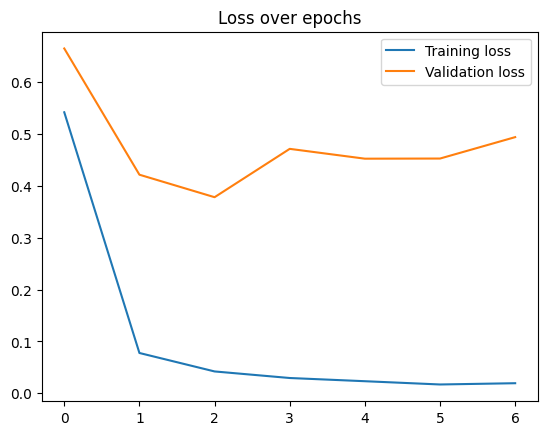

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [84]:
model.eval()
model=model.to(device)
all_logits = []
all_labels = []
# For each batch in our test set...
for sents, masks, labels in base_dataloader:
    sents, masks = sents.to(device), masks.to(device)
    # Compute logits
    with torch.no_grad():
        logits = model(sents, masks)
        all_logits.append(logits)
        all_labels.append(labels)
# Concatenate logits from each batch
all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim = 0).cpu().numpy()
# Apply softmax to calculate probabilities
probs = F.softmax(all_logits, dim=1).cpu().numpy()
preds = torch.argmax(all_logits, dim=1).flatten().cpu().numpy()
all_logits = all_logits.cpu().numpy()

In [87]:
preds_LOPS = list(pd.Series(preds).map(target_to_class))
print("L: " + str(preds_LOPS.count("L")))
print("P: " + str(preds_LOPS.count("P")))
print("S: " + str(preds_LOPS.count("S")))
print("O: " + str(preds_LOPS.count("O")))

L: 324
P: 31
S: 19
O: 60


In [101]:
# calculate metrics

acc = accuracy_score(all_labels, preds)
p = precision_score(all_labels, preds, average = None)
r = recall_score(all_labels, preds, average = None)
bal = balanced_accuracy_score(all_labels,preds)
f1 = f1_score(all_labels,preds, average = None)

print(acc)
print(p)
print(r)
print(bal)
print(f1)

0.8640552995391705
[0.94135802 0.56666667 0.58064516 0.94736842]
[0.9186747  0.59649123 0.7826087  0.81818182]
0.7789891101748371
[0.92987805 0.58119658 0.66666667 0.87804878]


In [68]:
#calibration phase: calculate a calibration curve. along with a base classifier density, we can get the base joint density and estimate the base prevalence

print("Base dataset: number of samples in each category")
base_labels =list(pd.Series(base_dataset.labels.numpy()).map(target_to_class))
print("L: " + str(base_labels.count("L")))
print("P: " + str(base_labels.count("P")))
print("S: " + str(base_labels.count("S")))
print("O: " + str(base_labels.count("O")))

Base dataset: number of samples in each category
L: 332
P: 23
S: 22
O: 57


In [69]:
all_logits
probs = F.softmax(all_logits, dim=1).cpu().numpy()

In [70]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(base_dataset.text.values)})

In [71]:
df

,probs_L,probs_O,probs_P,probs_S,gt_label,text
0,0.960235,0.022018,0.010005,0.007742,L,Human error in using a meterstick
1,0.960460,0.028065,0.006191,0.005283,L,angle of particle source
2,0.004421,0.002867,0.991475,0.001236,P,The distance from the slit to the screen
3,0.958171,0.028219,0.007347,0.006264,L,size and weight of ball
4,0.963500,0.021808,0.007961,0.006731,L,not releasing the ball at the top of the ramp
...,...,...,...,...,...,...
429,0.004992,0.002298,0.991490,0.001220,P,The randomly distributed motions of the water molecules on the slide.
430,0.579686,0.371316,0.015243,0.033756,O,start off
431,0.001920,0.001165,0.995748,0.001167,L,Earth's magnetic field bending electrons
432,0.910473,0.076568,0.006087,0.006871,L,Instrumental error


In [41]:
df["probs_L"]

0      0.960235
1      0.960460
2      0.004421
3      0.958171
4      0.963500
         ...   
429    0.004992
430    0.579686
431    0.001920
432    0.910473
433    0.959501
Name: probs_L, Length: 434, dtype: float32

(array([ 47.,  20.,  11.,  11.,   7.,   5.,   2.,   1.,   5.,   2.,   4.,
          4.,   1.,   6.,   2.,   5.,  11.,  12.,  21., 257.]),
 array([6.50385336e-04, 4.89658974e-02, 9.72814113e-02, 1.45596936e-01,
        1.93912446e-01, 2.42227957e-01, 2.90543467e-01, 3.38858962e-01,
        3.87174487e-01, 4.35490012e-01, 4.83805507e-01, 5.32121062e-01,
        5.80436587e-01, 6.28752112e-01, 6.77067578e-01, 7.25383103e-01,
        7.73698628e-01, 8.22014153e-01, 8.70329678e-01, 9.18645144e-01,
        9.66960669e-01]),
 <BarContainer object of 20 artists>)

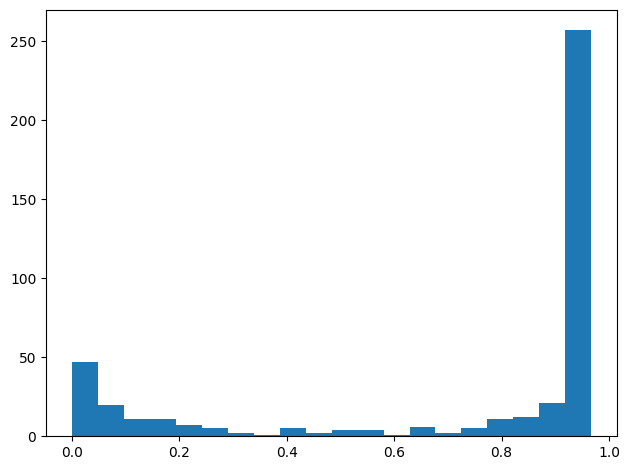

In [42]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_L"], bins = 20)

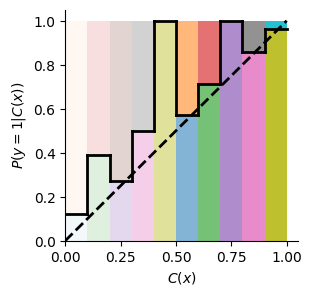

In [43]:
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "L", other_codes = ["O","P","S"])
binned_cal_curve.plot(show_diagonal=True)

In [44]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(base_dataset.text.values)})

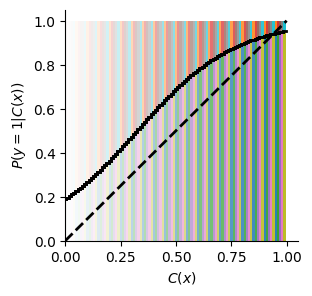

In [102]:
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "L", other_codes = ["O","P","S"])
platt_cal_curve.plot(show_diagonal=True, error_score = "raise")

In [46]:
# extrapolation phase: run probabilistic estimator

In [47]:
model.eval()
model=model.to(device)
all_logits = []
all_labels = []
# For each batch in our test set...
for sents, masks, labels in target_dataloader:
    sents, masks = sents.to(device), masks.to(device)
    # Compute logits
    with torch.no_grad():
        logits = model(sents, masks)
        all_logits.append(logits)
        all_labels.append(labels)
# Concatenate logits from each batch
all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim = 0)
# Apply softmax to calculate probabilities
probs = F.softmax(all_logits, dim=1).cpu().numpy()
preds = torch.argmax(all_logits, dim=1).flatten()


In [48]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})

## Calibration curves for L

(array([ 40.,  16.,  15.,  13.,   9.,   3.,   1.,   3.,   1.,   2.,   2.,
          2.,   2.,   4.,   5.,   6.,   7.,  12.,  30., 263.]),
 array([6.73506351e-04, 4.89650071e-02, 9.72565040e-02, 1.45548001e-01,
        1.93839505e-01, 2.42131010e-01, 2.90422499e-01, 3.38714004e-01,
        3.87005508e-01, 4.35297012e-01, 4.83588517e-01, 5.31880021e-01,
        5.80171525e-01, 6.28463030e-01, 6.76754534e-01, 7.25046039e-01,
        7.73337543e-01, 8.21629047e-01, 8.69920552e-01, 9.18212056e-01,
        9.66503561e-01]),
 <BarContainer object of 20 artists>)

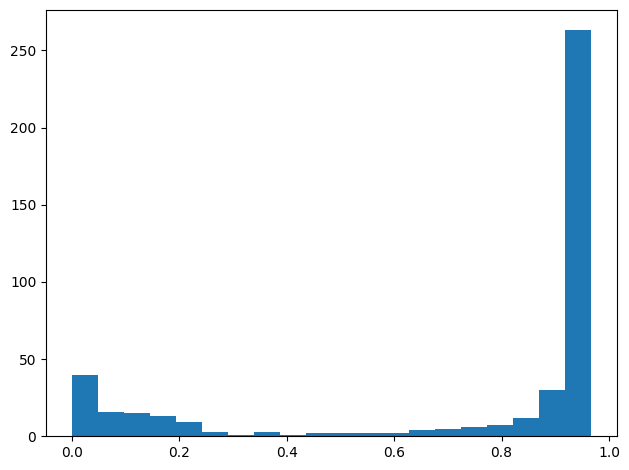

In [49]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_L"], bins = 20)

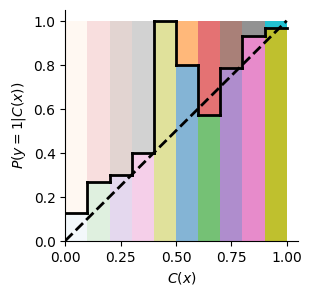

In [50]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "L", other_codes = ["O","P","S"])
binned_cal_curve.plot(show_diagonal=True)

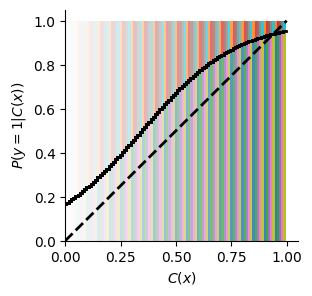

In [51]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "L", other_codes = ["O","P","S"])
platt_cal_curve.plot(show_diagonal=True)

In [52]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "L")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.773


In [53]:
print("Target dataset: number of samples in each category")
target_labels =list(pd.Series(target_dataset.labels.numpy()).map(target_to_class))
print("L: " + str(base_labels.count("L")))
print("P: " + str(base_labels.count("P")))
print("S: " + str(base_labels.count("S")))
print("O: " + str(base_labels.count("O")))

Target dataset: number of samples in each category
L: 332
P: 23
S: 22
O: 57


In [54]:
328/(328+27+11+68)

0.7557603686635944

In [55]:
list(preds.cpu().numpy()).count(0)/len(preds)

0.7637614678899083

In [56]:
display_data = pd.DataFrame(data = {"preds":list(pd.Series(preds.cpu().numpy()).map(target_to_class)), "labels":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})

In [57]:
pd.set_option('display.max_colwidth', None)
display_data[20:30]

,preds,labels,text
20,L,L,Slipping on the ramp.
21,L,L,Accidentally giving the ball an initial velocity
22,L,L,uncertainty in initial height and direction of the particle
23,L,L,Differences in distribution of particles in water between students
24,S,S,Looks like a decent Gaussian distribution due to random uncertainties in the measurements
25,L,O,Uncerainty
26,L,L,the initial velocity
27,L,L,a ruler is not a suitably-precise instrument for this task
28,L,L,Differences in drag
29,L,O,Error in measurement of time and distance


## Calibration curves for P

(array([407.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   1.,   2.,   0.,  19.]),
 array([4.27562743e-04, 5.02071753e-02, 9.99867916e-02, 1.49766400e-01,
        1.99546009e-01, 2.49325618e-01, 2.99105257e-01, 3.48884851e-01,
        3.98664474e-01, 4.48444098e-01, 4.98223692e-01, 5.48003256e-01,
        5.97782910e-01, 6.47562504e-01, 6.97342098e-01, 7.47121751e-01,
        7.96901345e-01, 8.46680939e-01, 8.96460593e-01, 9.46240187e-01,
        9.96019781e-01]),
 <BarContainer object of 20 artists>)

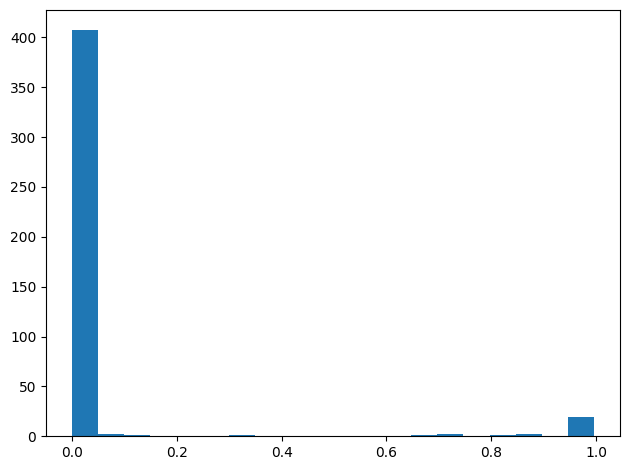

In [58]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_P"], bins = 20)

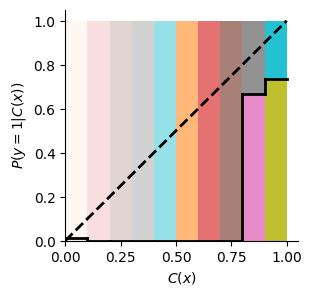

In [59]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "P", other_codes = ["O","L","S"])
binned_cal_curve.plot(show_diagonal=True)

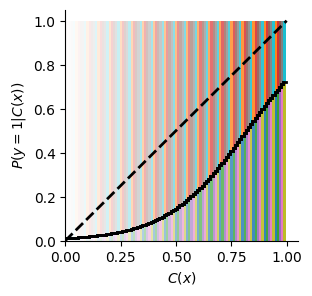

In [60]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "P", other_codes = ["O","L","S"])
platt_cal_curve.plot(show_diagonal=True)

In [61]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "P")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.048


## Calibration curves for S

(array([412.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,  16.]),
 array([0.00103713, 0.05088137, 0.10072561, 0.15056986, 0.20041409,
        0.25025833, 0.30010256, 0.3499468 , 0.39979103, 0.44963527,
        0.4994795 , 0.54932374, 0.599168  , 0.64901221, 0.69885647,
        0.74870068, 0.79854494, 0.84838921, 0.89823341, 0.94807768,
        0.99792188]),
 <BarContainer object of 20 artists>)

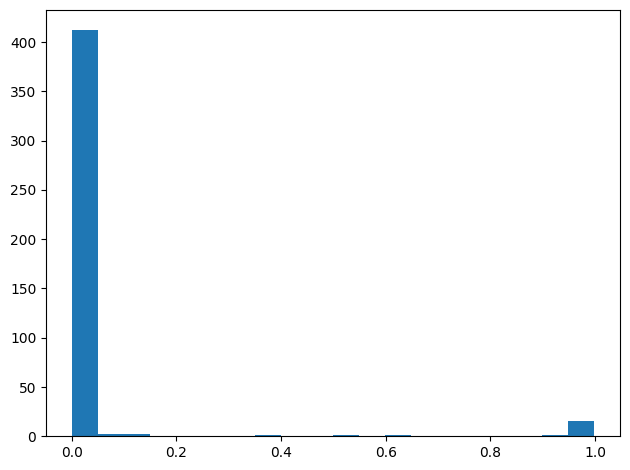

In [62]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_S"], bins = 20)

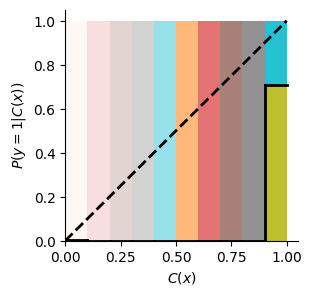

In [63]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "S", other_codes = ["O","P","L"])
binned_cal_curve.plot(show_diagonal=True)

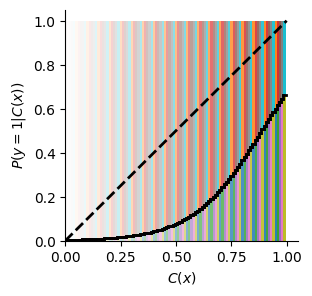

In [64]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "S", other_codes = ["O","P","L"])
platt_cal_curve.plot(show_diagonal=True)

In [65]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "S")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.030
